In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


file_path = r'C:\Users\nacho\OneDrive - University of Birmingham\DATA SCIENCE\Summer Project\all_player_data.csv'
df = pd.read_csv(file_path)

fullbacks = df[df['position'].str.lower() == 'full back']

C:\Users\nacho\anaconda\envs\notebook-6.1.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



✅ Best config:
n_neighbors=5, min_dist=0.05, k=3, silhouette=0.429


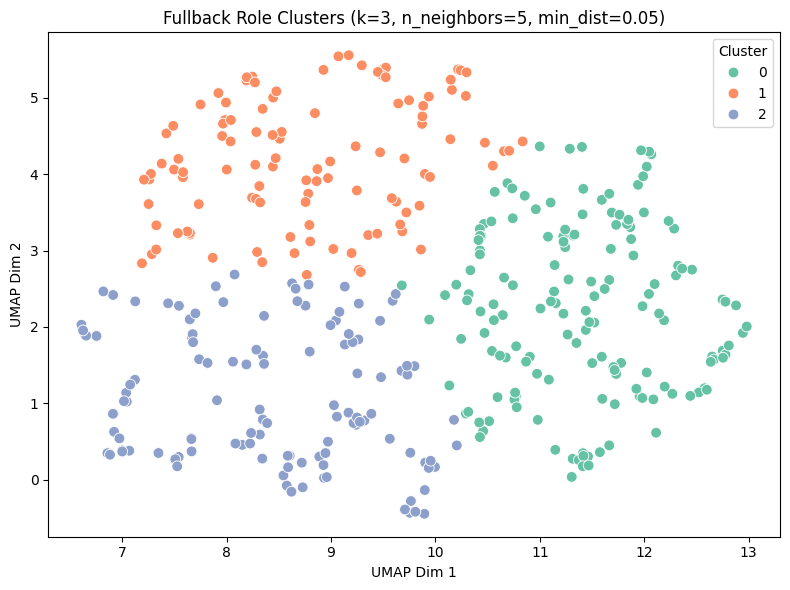

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# Combined fullback roles
FB_ROLES = ['left back', 'left wing back', 'right back', 'right wing back']

# Features to use
usable_features = [
    'passes_per_90', 'pass_accuracy', 'progressive_passes_per_90',
    'progressive_pass_accuracy', 'long_passes_per_90', 'long_pass_accuracy',
    'key_passes_per_90', 'assists_per_90',
    'crosses_per_90', 'cross_accuracy',
    'dribbles_per_90', 'successful_dribbles_per_90', 'dribble_success_rate',
    'progressive_runs_per_90', 'fouls_won_per_90',
    'pressures_per_90', 'blocks_per_90', 'interceptions_per_90',
    'dribbled_past_per_90', 'clearances_per_90', 'ball_recoveries_per_90',
    'fouls_made_per_90',
    'duels_per_90', 'duels_won_per_90', 'duel_success_rate',
    'touches_per_90', 'average_position_x', 'projected_y',
]

# Prepare data with Y projection
def prepare_projected_fullbacks(df):
    group = df[df["most_played_position"].str.lower().isin([r.lower() for r in FB_ROLES])].copy()
    group["projected_y"] = group["average_position_y"].apply(lambda y: 80 - y if y < 40 else y)
    X = group[usable_features].dropna()
    if len(X) < 10:
        return None, None
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, group

def find_best_k(X_embedded):
    best_k = None
    best_score = -1
    for k in range(2, 7):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_embedded)
        score = silhouette_score(X_embedded, labels)
        if score > best_score:
            best_k = k
            best_score = score
    return best_k, best_score

def cluster_and_plot(X_embedded, group, k, n_neighbors, min_dist):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_embedded)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=cluster_labels, palette='Set2', s=60)
    plt.title(f"Fullback Role Clusters (k={k}, n_neighbors={n_neighbors}, min_dist={min_dist})")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

# Load and prepare data
X_scaled, group = prepare_projected_fullbacks(df)
if X_scaled is None:
    print("Not enough data for fullbacks.")
    exit()

# Grid search
n_neighbors_list = [5, 10, 15, 30]
min_dist_list = [0.0, 0.05, 0.1, 0.3]

best_result = {'silhouette': -1}



for n_neighbors in n_neighbors_list:
    for min_dist in min_dist_list:
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
        X_umap = reducer.fit_transform(X_scaled)

        best_k, score = find_best_k(X_umap)
        #print(f"n_neighbors={n_neighbors}, min_dist={min_dist}, k={best_k}, silhouette={score:.3f}")

        if score > best_result['silhouette']:
            best_result.update({
                'silhouette': score,
                'n_neighbors': n_neighbors,
                'min_dist': min_dist,
                'best_k': best_k,
                'X_umap': X_umap
            })

# Display best and plot
print("\n✅ Best config:")
print(f"n_neighbors={best_result['n_neighbors']}, min_dist={best_result['min_dist']}, k={best_result['best_k']}, silhouette={best_result['silhouette']:.3f}")

cluster_and_plot(best_result['X_umap'], group, best_result['best_k'], best_result['n_neighbors'], best_result['min_dist'])


In [3]:
# Final KMeans with best parameters
final_kmeans = KMeans(n_clusters=best_result['best_k'], random_state=42, n_init=10)
final_labels = final_kmeans.fit_predict(best_result['X_umap'])

# Assign cluster labels to the original group DataFrame
group['cluster'] = final_labels

# Compute and display mean stats for each cluster
cluster_means = group.groupby('cluster')[usable_features].mean().round(3)
# Set option to display all columns
pd.set_option('display.max_columns', None)

print("\n=== Average Stats by Cluster ===")
print(cluster_means)

# (Optional) Reset to default after printing if you want
pd.reset_option('display.max_columns')


=== Average Stats by Cluster ===
         passes_per_90  pass_accuracy  progressive_passes_per_90  \
cluster                                                            
0               30.076         73.806                      9.800   
1               33.134         74.450                      9.892   
2               35.782         77.090                      9.811   

         progressive_pass_accuracy  long_passes_per_90  long_pass_accuracy  \
cluster                                                                      
0                           55.527               4.229              34.650   
1                           56.150               4.440              36.769   
2                           59.919               4.412              38.361   

         key_passes_per_90  assists_per_90  crosses_per_90  cross_accuracy  \
cluster                                                                      
0                    0.284           0.023           0.929          25.978   


In [4]:
for cluster_id, cluster_data in group.groupby('cluster'):
    print(f"\nCluster {cluster_id}:")
    for idx, row in cluster_data.iterrows():
        print(f"Player: {idx}, Name: {row['name']}, position {row['most_played_position']}")



Cluster 0:
Player: 56, Name: Laureano Sanabria Ruiz, position Right Back
Player: 58, Name: Fernando Navarro i Corbacho, position Left Back
Player: 69, Name: Carlos Martín Vigaray, position Right Back
Player: 70, Name: Damián Nicolás Suárez Suárez, position Right Back
Player: 86, Name: Miguel Torres Gómez, position Left Back
Player: 87, Name: Federico Ricca Rostagnol, position Left Back
Player: 102, Name: Antonio Manuel Luna Rodríguez, position Left Back
Player: 108, Name: Rubén Duarte Sánchez, position Left Back
Player: 116, Name: David García Santana, position Right Back
Player: 131, Name: Alberto Lora Ramos, position Right Back
Player: 138, Name: Mario Gaspar Pérez Martínez, position Right Back
Player: 140, Name: Antonio Rukavina, position Left Back
Player: 157, Name: Roberto Román Triguero, position Left Back
Player: 171, Name: Martín Montoya Torralbo, position Left Back
Player: 205, Name: Eneko Bóveda Altube, position Right Back
Player: 231, Name: Jonathan Castro Otto, position Le

In [6]:
# Your role names mapping (update as per your cluster insights)
fb_role_names = {
    0: 'Defensive Fullback',
    1: 'Balanced Fullback',
    2: 'Attacking Fullback',
    # Add more if best_k > 3
}

# Map cluster numbers to role names
group['role'] = group['cluster'].map(fb_role_names)


group.head()

,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,projected_y,cluster,role
10,6784,Antonio García Aranda,3719.52,Left Back,full back,32.810685,72.345133,9.485095,55.102041,4.645761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.248548,1,Balanced Fullback
15,6699,Ander Capa Rodríguez,4913.35,Right Back,full back,33.301108,62.541254,14.818810,47.713226,7.528468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.171539,1,Balanced Fullback
18,6776,David Juncà Reñé,3829.00,Left Back,full back,30.109689,67.056987,13.139201,51.699463,5.758684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.216584,1,Balanced Fullback
36,7906,David Simón Rodríguez Santana,3608.13,Right Back,full back,35.195517,78.454996,7.657706,58.631922,3.068071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.518159,1,Balanced Fullback
37,6932,Dani Castellano Betancor,3486.13,Left Back,full back,35.704348,80.260304,8.312943,61.801242,2.633293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.886338,1,Balanced Fullback


In [8]:
final = group.drop(columns = ['cluster', 'projected_y'])
final

,player_id,name,minutes,most_played_position,position,passes_per_90,pass_accuracy,progressive_passes_per_90,progressive_pass_accuracy,long_passes_per_90,...,collections_per_90,punches_per_90,sweeper_claims_per_90,sweeper_clears_per_90,save_percentage,smother_success_rate,collection_success_rate,punch_success_rate,sweeper_success_rate,role
10,6784,Antonio García Aranda,3719.52,Left Back,full back,32.810685,72.345133,9.485095,55.102041,4.645761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Balanced Fullback
15,6699,Ander Capa Rodríguez,4913.35,Right Back,full back,33.301108,62.541254,14.818810,47.713226,7.528468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Balanced Fullback
18,6776,David Juncà Reñé,3829.00,Left Back,full back,30.109689,67.056987,13.139201,51.699463,5.758684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Balanced Fullback
36,7906,David Simón Rodríguez Santana,3608.13,Right Back,full back,35.195517,78.454996,7.657706,58.631922,3.068071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Balanced Fullback
37,6932,Dani Castellano Betancor,3486.13,Left Back,full back,35.704348,80.260304,8.312943,61.801242,2.633293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Balanced Fullback
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976,4442,Maxime Poundjé,1858.20,Left Back,full back,32.547627,73.511905,8.572812,51.977401,4.504359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Attacking Fullback
1977,4823,Milan Gajić,858.22,Right Back,full back,30.306914,70.934256,10.381953,49.494949,3.984992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Defensive Fullback
1996,7707,François Clerc,1343.00,Right Back,full back,36.455696,74.264706,13.536858,58.910891,4.892033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Attacking Fullback
2002,44065,William Matheus da Silva,1873.08,Left Back,full back,31.183932,70.107858,10.522775,54.794521,4.372477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Attacking Fullback


In [9]:
final.to_csv('fb_roles.csv', index=False)